# Cross Spectra
This tutorial shows how to make and manipulate a cross spectrum of two light curves using Stingray.

In [1]:
pip install astropy scipy matplotlib numpy h5py tqdm numba pint-pulsar emcee corner statsmodels pyfftw tbb

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytest pytest-astropy jinja2 docutils sphinx-astropy nbsphinx pandoc ipython jupyter notebook towncrier tox black

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stingray

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

# 1. Create two light curves
There are two ways to make Lightcurve objects. We’ll show one way here. Check out “Lightcurve/Lightcurve tutorial.ipynb” for more examples.

Generate an array of relative timestamps that’s 8 seconds long, with dt = 0.03125 s, and make two signals in units of counts. The first is a sine wave with amplitude = 300 cts/s, frequency = 2 Hz, phase offset = 0 radians, and mean = 1000 cts/s. The second is a sine wave with amplitude = 200 cts/s, frequency = 2 Hz, phase offset = pi/4 radians, and mean = 900 cts/s. We then add Poisson noise to the light curves.



In [5]:
dt = 0.03125  # seconds
exposure = 8.  # seconds
times = np.arange(0, exposure, dt)  # seconds

signal_1 = 300 * np.sin(2.*np.pi*times/0.5) + 1000  # counts/s
signal_2 = 200 * np.sin(2.*np.pi*times/0.5 + np.pi/4) + 900  # counts/s
noisy_1 = np.random.poisson(signal_1*dt)  # counts
noisy_2 = np.random.poisson(signal_2*dt)  # counts

In [6]:
lc1 = Lightcurve(times, noisy_1)
lc2 = Lightcurve(times, noisy_2)

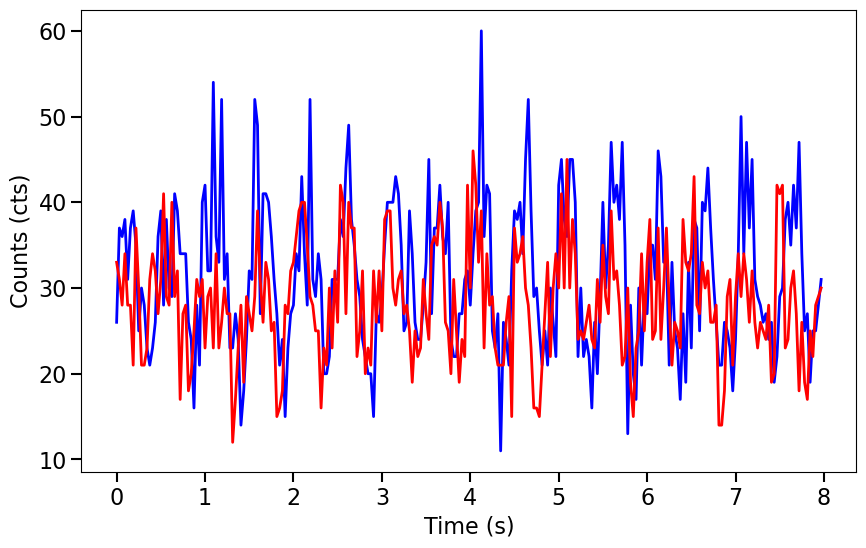

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(lc1.time, lc1.counts, lw=2, color='blue')
ax.plot(lc1.time, lc2.counts, lw=2, color='red')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

# 2. Pass both of the light curves to the Crossspectrum class to create a Crossspectrum object.
The first Lightcurve passed is the channel of interest or interest band, and the second Lightcurve passed is the reference band. You can also specify the optional attribute norm if you wish to normalize the real part of the cross spectrum to squared fractional rms, Leahy, or squared absolute normalization. The default normalization is ‘frac’.

In [8]:
cs = Crossspectrum.from_lightcurve(lc1, lc2)
print(cs)

/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:883: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:899: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(


We can print the first five values in the arrays of the positive Fourier frequencies and the cross power. The cross power has a real and an imaginary component.

In [9]:
print(cs.freq[0:5])
print(cs.power[0:5])

[0.125 0.25  0.375 0.5   0.625]
[ 7.33502621e+03-3730.38952484j -3.82534381e+03+5648.87141275j
 -2.30571486e+03 +380.85081419j -3.79502202e+03 -181.79598397j
 -4.61744722e-01+4044.73759332j]


Since the negative Fourier frequencies (and their associated cross powers) are discarded, the number of time bins per segment n is twice the length of freq and power.

In [10]:
print("Size of positive Fourier frequencies: %d" % len(cs.freq))
print("Number of data points per segment: %d" % cs.n)

Size of positive Fourier frequencies: 127
Number of data points per segment: 256


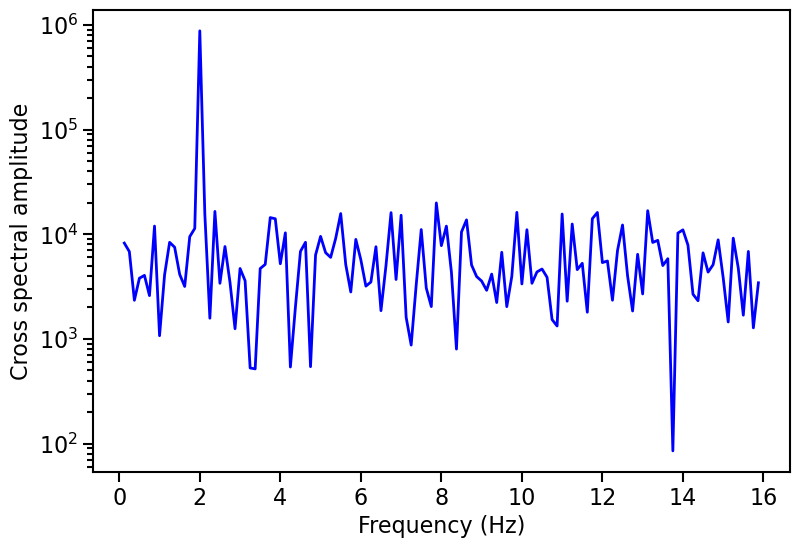

In [11]:
cs_amplitude = np.abs(cs.power)  # The mod square of the real and imaginary components

fig, ax1 = plt.subplots(1,1,figsize=(9,6), sharex=True)
ax1.plot(cs.freq, cs_amplitude, lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Cross spectral amplitude", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

You’ll notice that the cross spectrum is a bit noisy. This is because we’re only using one segment of data. Let’s try averaging together multiple segments of data. # Averaged cross spectrum example You could use two long Lightcurves and have AveragedCrossspectrum chop them into specified segments, or give two lists of Lightcurves where each segment of Lightcurve is the same length. We’ll show the first way here. Remember to check the Lightcurve tutorial notebook for fancier ways of making light curves. ## 1. Create two long light curves. Generate an array of relative timestamps that’s 1600 seconds long, and two signals in count rate units, with the same properties as the previous example. We then add Poisson noise and turn them into Lightcurve objects.

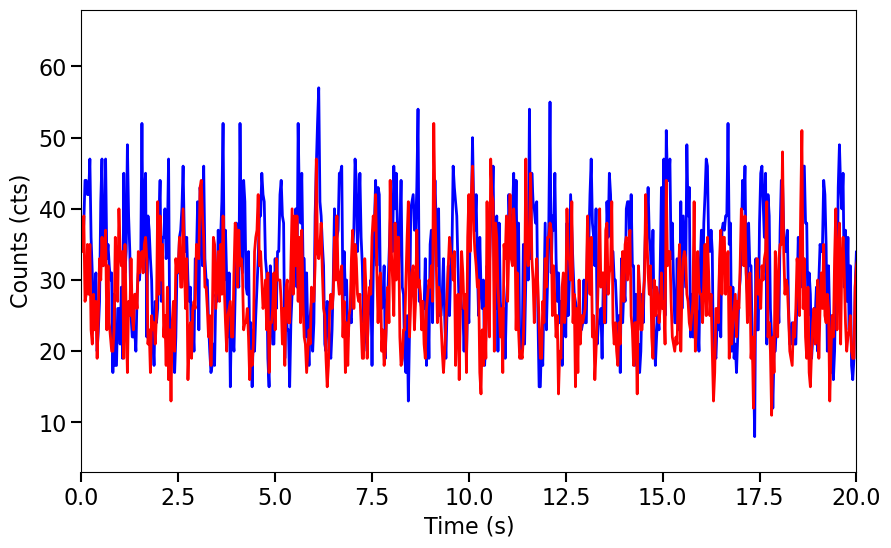

In [12]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

# In count rate units here
long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 1000  # counts/s
long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 900  # counts/s

# Multiply by dt to get count units, then add Poisson noise
long_noisy_1 = np.random.poisson(long_signal_1*dt)  # counts
long_noisy_2 = np.random.poisson(long_signal_2*dt)  # counts

long_lc1 = Lightcurve(long_times, long_noisy_1)
long_lc2 = Lightcurve(long_times, long_noisy_2)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(long_lc1.time, long_lc1.counts, lw=2, color='blue')
ax.plot(long_lc1.time, long_lc2.counts, lw=2, color='red')
ax.set_xlim(0,20)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

# 2. Pass both light curves to the AveragedCrossspectrum class with a specified segment_size.
If the exposure (length) of the light curve cannot be divided by segment_size with a remainder of zero, the last incomplete segment is thrown out, to avoid signal artefacts. Here we’re using 8 second segments.

In [13]:
avg_cs = AveragedCrossspectrum.from_lightcurve(long_lc1, long_lc2, 8.)

200it [00:00, 7587.24it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:897: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/conda/lib/python3.11/site-packages/stingray/crossspectrum.py:2808: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


Again we can print the first five Fourier frequencies and first five cross spectral values, as well as the number of segments.

In [14]:
print(avg_cs.freq[0:5])
print(avg_cs.power[0:5])
print("\nNumber of segments: %d" % avg_cs.m)

[0.125 0.25  0.375 0.5   0.625]
[-340.62122316 +70.92357827j  976.3360288 +320.22612575j
   87.67866273 +96.21046775j -685.80371391-217.72641136j
  151.16070551 -84.82352865j]

Number of segments: 200


If m is less than 50 and you try to compute the coherence, a warning will pop up letting you know that your number of segments is significantly low, so the error on coherence might not follow the expected (Gaussian) statistical distributions.

In [15]:
test_cs = AveragedCrossspectrum.from_lightcurve(long_lc1, long_lc2, 40.)
print(test_cs.m)
coh, err = test_cs.coherence()

40it [00:00, 4818.27it/s]

40



/opt/conda/lib/python3.11/site-packages/stingray/utils.py:267: UserWarning: SIMON says: Number of segments used in averaging is significantly low. The result might not follow the expected statistical distributions.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


# Properties
An AveragedCrossspectrum object has the following properties, same as Crossspectrum :

freq : Numpy array of mid-bin frequencies that the Fourier transform samples.

power : Numpy array of the averaged cross spectrum (complex numbers).

df : The frequency resolution (in Hz).

m : The number of cross spectra averaged together, equal to the number of whole segments in a light curve.

n : The number of data points (time bins) in one segment of the light curves.

nphots1 : The total number of photons in the first (interest) light curve.

nphots2 : The total number of photons in the second (reference) light curve.

Let’s plot the amplitude of the averaged cross spectrum!

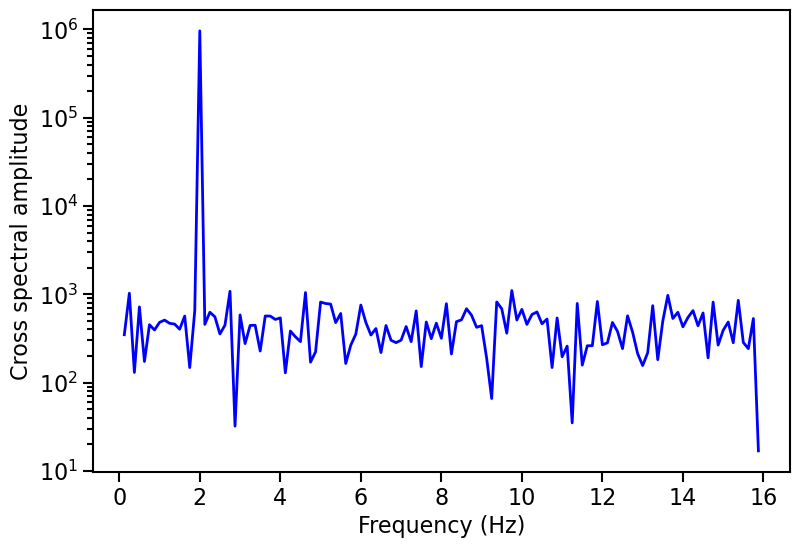

In [16]:
avg_cs_amplitude = np.abs(avg_cs.power)

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_cs.freq, avg_cs_amplitude, lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Cross spectral amplitude", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

# Normalizating the cross spectrum
The three kinds of normalization are: * leahy: Leahy normalization. Makes the Poisson noise level 
. See Leahy et al. 1983, ApJ, 266, 160L. * frac: Fractional rms-squared normalization, also known as rms normalization. Makes the Poisson noise level 
. See Belloni & Hasinger 1990, A&A, 227, L33, and Miyamoto et al. 1992, ApJ, 391, L21.. This is the default. * abs: Absolute rms-squared normalization, also known as absolute normalization. Makes the Poisson noise level 
. See insert citation. * none: No normalization applied.

Note that these normalizations and the Poisson noise levels apply to the “cross power”, not the cross-spectral amplitude.

In [17]:
avg_cs_leahy = AveragedCrossspectrum.from_lightcurve(long_lc1, long_lc2, 8., norm='leahy')
avg_cs_frac = AveragedCrossspectrum.from_lightcurve(long_lc1, long_lc2, 8., norm='frac')
avg_cs_abs = AveragedCrossspectrum.from_lightcurve(long_lc1, long_lc2, 8., norm='abs')

200it [00:00, 7740.71it/s]
200it [00:00, 7776.16it/s]
200it [00:00, 7268.21it/s]


/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


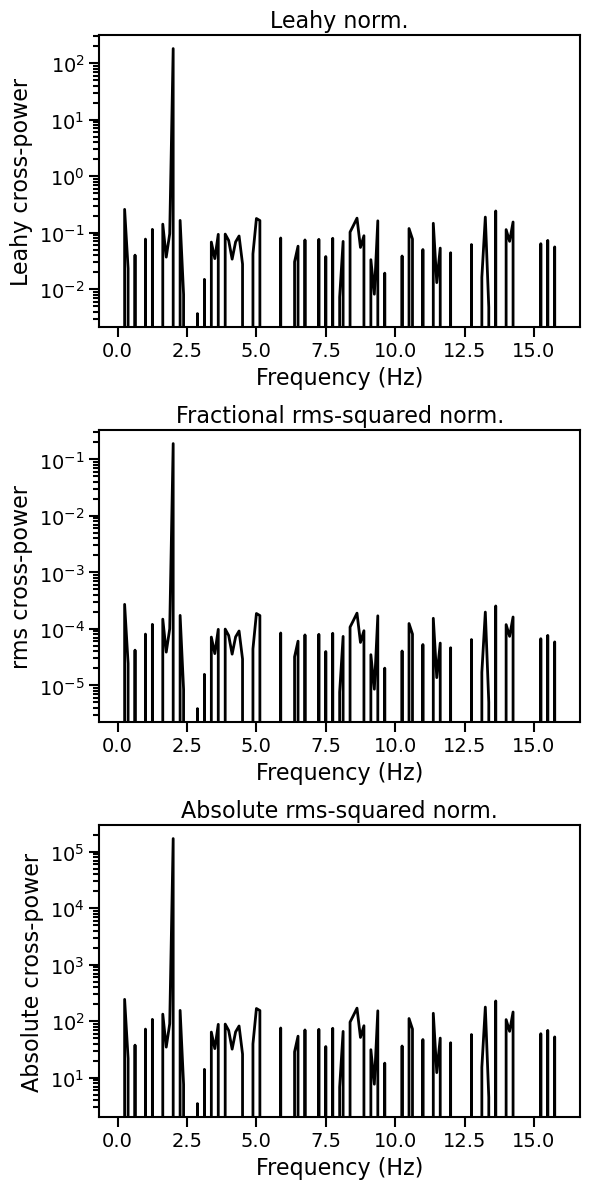

In [18]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(6,12))
ax1.plot(avg_cs_leahy.freq, avg_cs_leahy.power, lw=2, color='black')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Leahy cross-power", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
ax1.set_title("Leahy norm.", fontproperties=font_prop)

ax2.plot(avg_cs_frac.freq, avg_cs_frac.power, lw=2, color='black')
ax2.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax2.set_ylabel("rms cross-power", fontproperties=font_prop)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_yscale('log')
ax2.tick_params(which='major', width=1.5, length=7)
ax2.tick_params(which='minor', width=1.5, length=4)
ax2.set_title("Fractional rms-squared norm.", fontproperties=font_prop)

ax3.plot(avg_cs_abs.freq, avg_cs_abs.power, lw=2, color='black')
ax3.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax3.set_ylabel("Absolute cross-power", fontproperties=font_prop)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_yscale('log')
ax3.tick_params(which='major', width=1.5, length=7)
ax3.tick_params(which='minor', width=1.5, length=4)
ax3.set_title("Absolute rms-squared norm.", fontproperties=font_prop)

for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)
    ax3.spines[axis].set_linewidth(1.5)
plt.tight_layout()
plt.show()

# Re-binning a cross spectrum in frequency¶
Typically, rebinning is done on an averaged, normalized cross spectrum. ## 1. We can linearly re-bin a cross spectrum (although this is not done much in practice)



In [19]:
print("DF before:", avg_cs.df)
# Both of the following ways are allowed syntax:
# lin_rb_cs = Crossspectrum.rebin(avg_cs, 0.25, method='mean')
lin_rb_cs = avg_cs.rebin(0.25, method='mean')
print("DF after:", lin_rb_cs.df)

DF before: 0.125
DF after: 0.25


# 2. And we can logarithmically/geometrically re-bin a cross spectrum
In this re-binning, each bin size is 1+f times larger than the previous bin size, where f is user-specified and normally in the range 0.01-0.1. The default value is f=0.01.

Logarithmic rebinning only keeps the real part of the cross spectum.

In [20]:
# Both of the following ways are allowed syntax:
# log_rb_cs, log_rb_freq, binning = Crossspectrum.rebin_log(avg_cs, f=0.02)
log_rb_cs = avg_cs.rebin_log(f=0.02)

Note that like rebin, rebin_log returns a Crossspectrum or AveragedCrossspectrum object (depending on the input object):

In [21]:
print(type(lin_rb_cs))

<class 'stingray.crossspectrum.AveragedCrossspectrum'>


# Time lags / phase lags
# 1. Frequency-dependent lags
The lag-frequency spectrum shows the time lag between two light curves (usually non-overlapping broad energy bands) as a function of Fourier frequency. See Uttley et al. 2014, A&ARev, 22, 72 section 2.2.1.

In AveragedCrossspectrum, the second light curve is what is considered the reference in Uttley et al. and in most other spectral timing literature.

30it [00:00, 167.29it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:897: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:899: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/opt/conda/lib/python3.11/site-packages/stingray/crossspectrum.py:2808: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


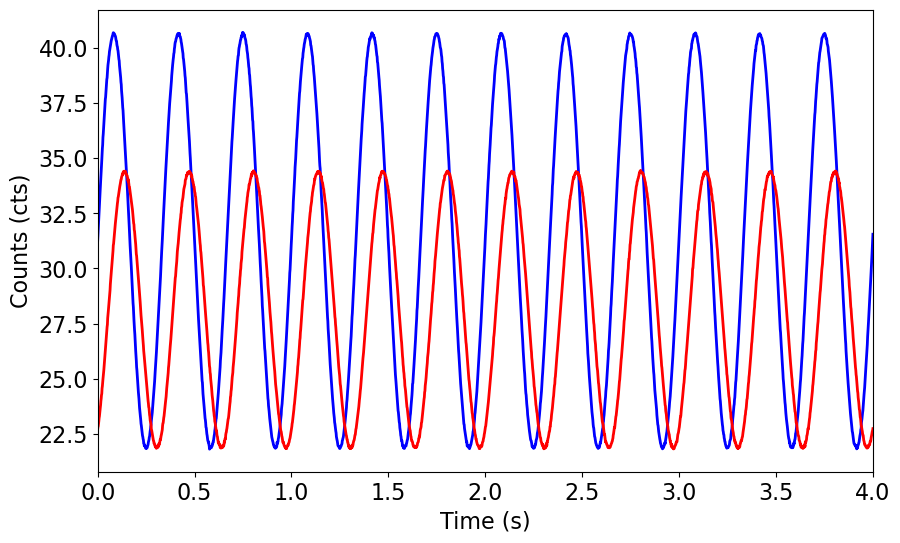

/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


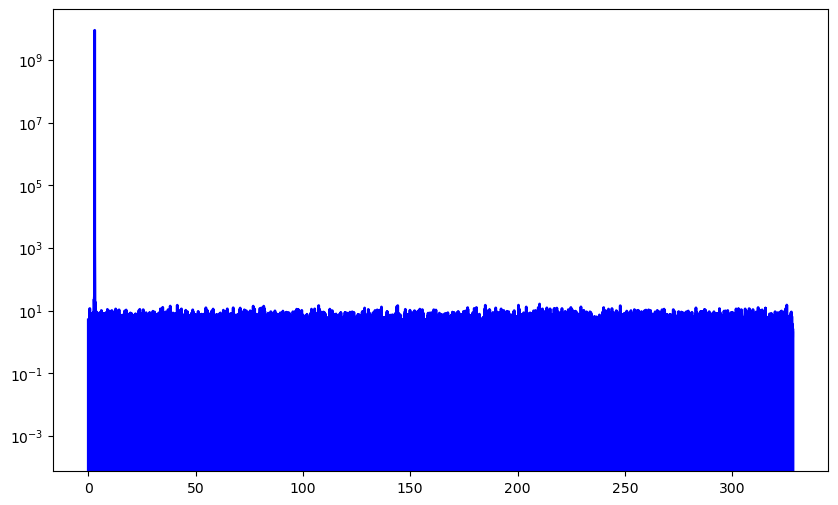

In [22]:
long_dt = 0.0015231682473469295763529  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds
frequency = 3.
phase_lag = np.pi / 3

# long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 100 * np.sin(2.*np.pi*long_times*5 + np.pi/6) + 1000
# long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 80 * np.sin(2.*np.pi*long_times*5) + 900

long_signal_1 = (300 * np.sin(2.*np.pi*long_times*frequency) + 1000) * dt
long_signal_2 = (200 * np.sin(2.*np.pi*long_times*frequency - phase_lag) + 900) * dt

long_lc1 = Lightcurve(long_times, np.random.normal(long_signal_1, 0.03))
long_lc2 = Lightcurve(long_times, np.random.normal(long_signal_2, 0.03))

# Note: the second light curve is what we use as a reference.
avg_cs = AveragedCrossspectrum.from_lightcurve(long_lc2, long_lc1, 53.)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(long_lc1.time, long_lc1.counts, lw=2, color='blue')
ax.plot(long_lc1.time, long_lc2.counts, lw=2, color='red')
ax.set_xlim(0,4)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(avg_cs.freq, avg_cs.power, lw=2, color='blue')
plt.semilogy()
plt.show()

the time_lag method returns an np.ndarray with the time lag in seconds per positive Fourier frequency.

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:267: UserWarning: SIMON says: Number of segments used in averaging is significantly low. The result might not follow the expected statistical distributions.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


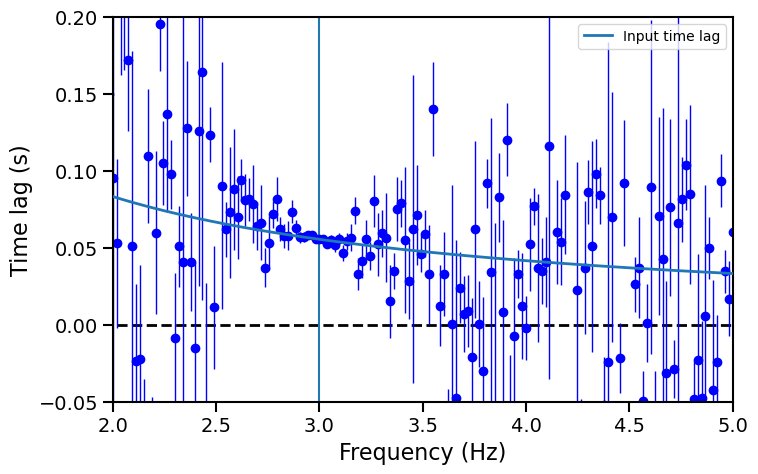

In [23]:
freq_lags, freq_lags_err = avg_cs.time_lag()
freq_plags, freq_plags_err = avg_cs.phase_lag()

# Expected time lag, given the input time lag
time_lag = phase_lag / (2. * np.pi * avg_cs.freq)
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hlines(0, avg_cs.freq[0], avg_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.errorbar(avg_cs.freq, freq_lags, yerr=freq_lags_err,fmt="o", lw=1, color='blue')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Time lag (s)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
# plt.semilogx()
plt.axvline(frequency)
plt.xlim([2, 5])
plt.ylim([-0.05, 0.2])
plt.plot(avg_cs.freq, time_lag, label="Input time lag", lw=2, zorder=10)
plt.legend()
plt.show()

In [24]:
print(freq_lags)

[-2.00544193e+00  7.71881737e+00  4.83066396e+00 ...  1.44135727e-03
 -5.44020243e-04 -8.88421190e-04]


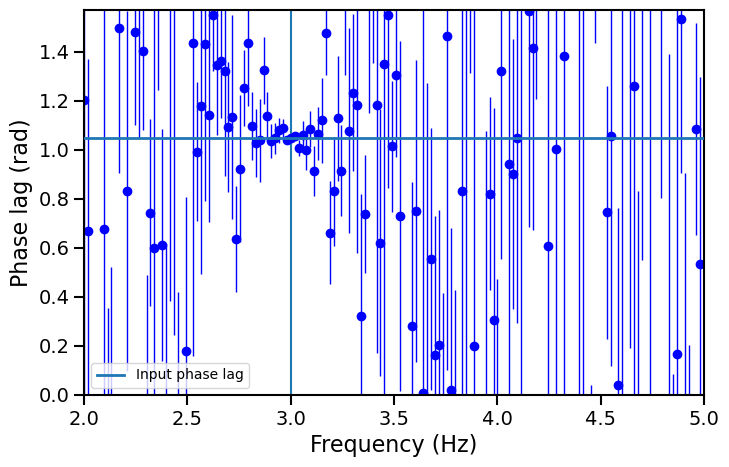

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hlines(0, avg_cs.freq[0], avg_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.errorbar(avg_cs.freq, freq_plags, yerr=freq_plags_err,fmt="o", lw=1, color='blue')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Phase lag (rad)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
# plt.semilogx()
plt.axvline(frequency)
plt.xlim([2, 5])
plt.ylim([0, np.pi/ 2])
plt.axhline(phase_lag, label="Input phase lag", lw=2, zorder=10)
plt.legend()
plt.show()

# 2. Energy-dependent lags
The lag vs energy spectrum can be calculated using the LagEnergySpectrum from stingray.varenergy. Refer to the Spectral Timing documentation.

# Coherence
Coherence is a Fourier-frequency-dependent measure of the linear correlation between time series measured simultaneously in two energy channels. See Vaughan and Nowak 1997, ApJ, 474, L43 and Uttley et al. 2014, A&ARev, 22, 72 section 2.1.3.

In [26]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 1000
long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 900

long_noisy_1 = np.random.poisson(long_signal_1*dt)
long_noisy_2 = np.random.poisson(long_signal_2*dt)

long_lc1 = Lightcurve(long_times, long_noisy_1)
long_lc2 = Lightcurve(long_times, long_noisy_2)

avg_cs = AveragedCrossspectrum.from_lightcurve(long_lc1, long_lc2, 8.)

200it [00:00, 8717.43it/s]


In [27]:
coh, err_coh = avg_cs.coherence()

print(len(coh) == len(avg_cs.freq))

True


The coherence and uncertainty have the same length as the positive Fourier frequencies.

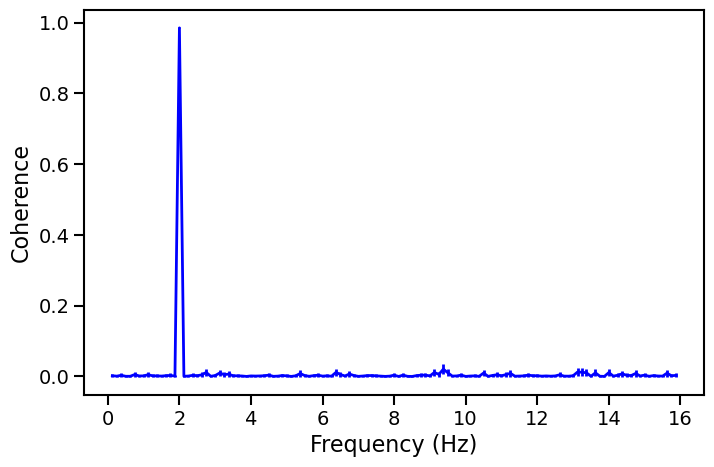

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
# ax.hlines(0, avg_cs.freq[0], avg_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.errorbar(avg_cs.freq, coh, yerr=err_coh, lw=2, color='blue')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Coherence", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.show()

# CrossCorrelation
This Tutorial is intended to give a demostration of How to make a CrossCorrelation Object in Stingray Library.
# 1. Create two light curves
There are two ways to create a Lightcurve. 1) Using an array of time stamps and an array of counts. 2) From the Photon Arrival times.

In this example, Lightcurve is created using arrays of time stamps and counts.

Generate an array of relative timestamps that’s 10 seconds long, with dt = 0.03125 s, and make two signals in units of counts. The signal is a sine wave with amplitude = 300 cts/s, frequency = 2 Hz, phase offset of pi/2 radians, and mean = 1000 cts/s. We then add Poisson noise to the light curve.

In [29]:
import numpy as np
from stingray import Lightcurve
from stingray.crosscorrelation import CrossCorrelation

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

In [30]:
dt = 0.03125  # seconds
exposure = 10.  # seconds
freq = 1   # Hz
times = np.arange(0, exposure, dt)  # seconds

signal_1 = 300 * np.sin(2.*np.pi*freq*times) + 1000  # counts/s
signal_2 = 300 * np.sin(2.*np.pi*freq*times + np.pi/2) + 1000  # counts/s
noisy_1 = np.random.poisson(signal_1*dt)  # counts
noisy_2 = np.random.poisson(signal_2*dt)  # counts

In [31]:
lc1 = Lightcurve(times, noisy_1)
lc2 = Lightcurve(times, noisy_2)

len(lc1)

320

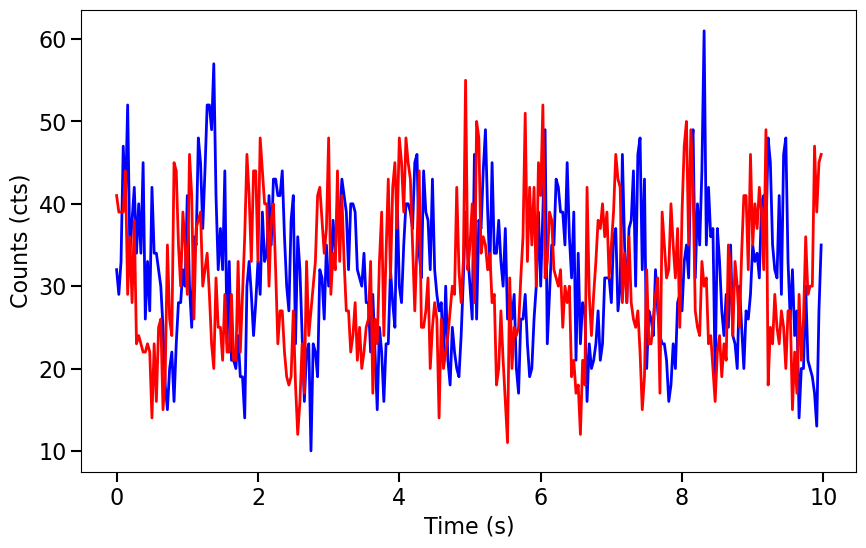

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(lc1.time, lc1.counts, lw=2, color='blue')
ax.plot(lc1.time, lc2.counts, lw=2, color='red')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

# 2. Create a CrossCorrelation Object from two Light curves created above
To create a CrossCorrelation Object from LightCurves, simply pass both Lightvurves created above into the CrossCorrelation.

In [33]:
cr = CrossCorrelation(lc1, lc2)

Now, Cross Correlation values are stored in attribute corr, which is called below

In [34]:
cr.corr[:10]

array([ 157.675     , 1238.84306641, 3225.56425781, 3619.72919922,
       4991.03476562, 6181.95283203, 7294.62089844, 8184.36083984,
       7686.69140625, 7490.34384766])

In [35]:
# Time Resolution for Cross Correlation is same as that of each of the Lightcurves
cr.dt

0.03125

# 3. Plot Cross Correlation for Different lags
To visulaize correlation for different values of time lags, simply call plot function on cs.

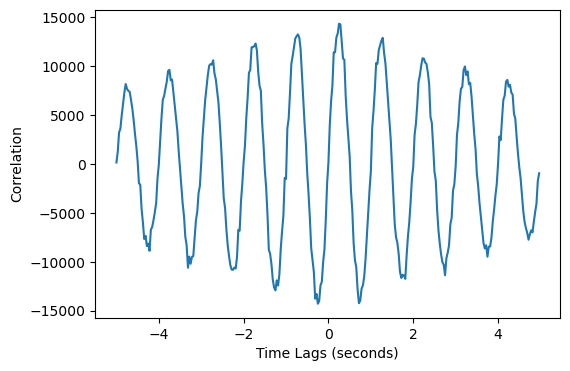

<Axes: xlabel='Time Lags (seconds)', ylabel='Correlation'>

In [36]:
cr.plot(labels = ['Time Lags (seconds)','Correlation'])

Given the Phase offset of pi/2 between two lightcurves created above, and freq=1 Hz, time_shift should be close to 0.25 sec. Small error is due to time resolution.

In [37]:
cr.time_shift #seconds

0.25

Modes of Correlation
You can also specify an optional argument on modes of cross-correlation. There are three modes : 1) same 2) valid 3) full

Visit following ink on more details on mode : https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.correlate.html

Default mode is ‘same’ and it gives output equal to the size of larger lightcurve and is most common in astronomy. You can see mode of your CrossCorrelation by calling mode attribute on the object.

In [38]:
# The number of data points in corr and largest lightcurve are same in this mode.

cr.n

320

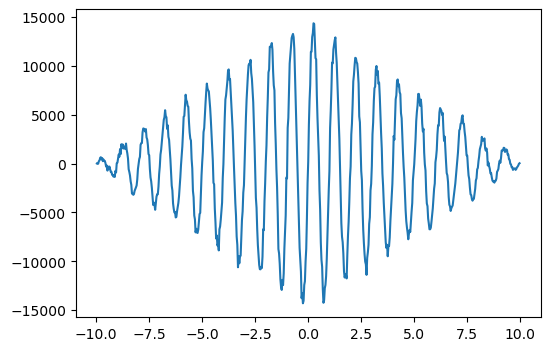

<Axes: >

In [39]:
# Creating CrossCorrelation with full mode now using same data as above.

cr1 = CrossCorrelation(lc1, lc2, mode = 'full')
cr1.plot()

# Another Example
You can also create CrossCorrelation Object by using Cross Correlation data. This can be useful in some cases when you have correlation data and want to calculate time shift for max. correlation. You need to specify time resolution for correlation(default value of 1.0 seconds is used otherwise).

In [40]:
cs = CrossCorrelation()
cs.corr = np.array([ 660,  1790,  3026,  4019,  5164,  6647,  8105,  7023, 6012, 5162])
time_shift, time_lags, n = cs.cal_timeshift(dt=0.5)

AttributeError: 'NoneType' object has no attribute 'counts'

# Yet another Example with longer Lingcurve
I will be using same lightcurves as in the example above but with much longer duration and shorter lags. Both Lightcurves are chosen to be more or less same with a certain phase shift to demonstrate Correlation in a better way.

Again Generating two signals this time without poission noise so that time lag can be demonstrated. For noisy lightcurves, accurate calculation requires interpolation.

In [ ]:
dt = 0.0001  # seconds
exposure = 50.  # seconds
freq = 1       # Hz
times = np.arange(0, exposure, dt)  # seconds

signal_1 = 300 * np.sin(2.*np.pi*freq*times) + 1000 * dt # counts/s
signal_2 = 200 * np.sin(2.*np.pi*freq*times + np.pi/2) + 900 * dt  # counts/s

In [ ]:
# Converting noisy signals into Lightcurves.

lc1 = Lightcurve(times, signal_1)
lc2 = Lightcurve(times, signal_2)

len(lc1)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(lc1.time, lc1.counts, lw=2, color='blue')
ax.plot(lc1.time, lc2.counts, lw=2, color='red')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

In [ ]:
# Now, creating CrossCorrelation Object by passing lc1 and lc2 into the constructor.

cs = CrossCorrelation(lc1, lc2)
print('Done')

In [ ]:
cs.corr[:50]

In [ ]:
# Time Resolution for Cross Correlation is same as that of each of the Lightcurves
cs.dt

In [ ]:
cs.plot( ['Time Lags (seconds)','Correlation'])

In [ ]:
cs.time_shift #seconds

# AutoCorrelation
Stingray has also separate class for AutoCorrelation. AutoCorrealtion is similar to crosscorrelation but involves only One Lightcurve.i.e. Correlation of Lightcurve with itself.

AutoCorrelation is part of stingray.crosscorrelation module. Following line imports AutoCorrelation.

In [ ]:
from stingray.crosscorrelation import AutoCorrelation

To create AutoCorrelation object, simply pass lightcurve into AutoCorrelation Constructor. Using same Lighrcurve created above to demonstrate AutoCorrelation.

In [ ]:
lc = lc1
ac = AutoCorrelation(lc)
ac.n

In [ ]:
ac.corr[:10]

In [ ]:
ac.time_lags

In [ ]:
ac.time_shift

In [ ]:
ac.plot()